In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers, losses

2023-12-14 11:24:46.744475: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 11:24:46.935375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 11:24:46.935404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 11:24:46.968408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 11:24:47.034487: I tensorflow/core/platform/cpu_feature_guar

#### Simple Sentiment Analysis

- Get and explore IMBD data
- `tf.keras.utils.text_dataset_from_directory`: You can use this if the file system for the data is set up right

In [28]:
DATAPTH = '../data'
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclIMBD_v1", url, untar=True, cache_dir=DATAPTH, cache_subdir='')


84125825/84125825 [==============================] - 3s 0us/step


In [29]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['README', 'imdbEr.txt', 'train', 'test', 'imdb.vocab']

In [30]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_neg.txt',
 'urls_pos.txt',
 'neg',
 'unsup',
 'urls_unsup.txt',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos']

In [34]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [35]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [36]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    DATAPTH + '/aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


So the solution here for getting rid of the unsupervised files was literally to just get rid of the folder lol

In [37]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [44]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    DATAPTH + '/aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [45]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    DATAPTH + '/aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


#### Preparing data for training
- tf.keras.layers.TextVectorization

In [50]:
def custom_standardization(input_data): # Removes HTML
    lower = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lower, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [51]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features, # Maximum size of vocabulary
    output_mode='int',
    output_sequence_length = sequence_length # Each sentence length, padded or truncated
)

In [52]:
# Make text-only dataset (no labels), the call adapt
train_text = raw_train_ds.map(lambda x,y: x)
vectorize_layer.adapt(train_text) # the layer will build a vocabulary of all string tokens seen in the dataset. Used only on training data

In [54]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [55]:
# Let's take a look at this
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print('Review', first_review)
print('Label', raw_train_ds.class_names[first_label])
print('Vectorized Review', vectorize_text(first_review, first_label))

Review tf.Tensor(b'Recipe for one of the worst movies of all time: a she-male villain who looks like it escaped from the WWF, has terrible aim with a gun that has inconsistent effects (the first guy she shoots catches on fire but when she shoots anyone else they just disappear) and takes time out to pet a deer. Then you got the unlikable characters, 30 year old college students, a lame attempt at a surprise ending and lots, lots more. Avoid at all costs.', shape=(), dtype=string)
Label neg
Vectorized Review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[9257,   15,   28,    5,    2,  241,   91,    5,   30,   58,    4,
           1, 1011,   36,  262,   38,    9, 3891,   35,    2,    1,   43,
         382, 5223,   16,    4, 1113,   12,   43, 5739,  300,    2,   83,
         225,   55, 3209, 3898,   20,  973,   18,   51,   55, 3209,  250,
         320,   34,   40, 4386,    3,  294,   58,   44,    6, 2911,    4,
        6757,   92,   22,  184,    2, 4916,  100, 1221,  336,  161, 

In [69]:
# Let's look at what each token is
for i in range(250):
    item = vectorize_text(first_review, first_label)[0][0][i]
    value = tf.keras.backend.get_value(item)
    if value == 0:
        continue
    print(value, " --->", vectorize_layer.get_vocabulary()[value])
print('Vocabulary Size: ', len(vectorize_layer.get_vocabulary()))


9257  ---> recipe
15  ---> for
28  ---> one
5  ---> of
2  ---> the
241  ---> worst
91  ---> movies
5  ---> of
30  ---> all
58  ---> time
4  ---> a
1  ---> [UNK]
1011  ---> villain
36  ---> who
262  ---> looks
38  ---> like
9  ---> it
3891  ---> escaped
35  ---> from
2  ---> the
1  ---> [UNK]
43  ---> has
382  ---> terrible
5223  ---> aim
16  ---> with
4  ---> a
1113  ---> gun
12  ---> that
43  ---> has
5739  ---> inconsistent
300  ---> effects
2  ---> the
83  ---> first
225  ---> guy
55  ---> she
3209  ---> shoots
3898  ---> catches
20  ---> on
973  ---> fire
18  ---> but
51  ---> when
55  ---> she
3209  ---> shoots
250  ---> anyone
320  ---> else
34  ---> they
40  ---> just
4386  ---> disappear
3  ---> and
294  ---> takes
58  ---> time
44  ---> out
6  ---> to
2911  ---> pet
4  ---> a
6757  ---> deer
92  ---> then
22  ---> you
184  ---> got
2  ---> the
4916  ---> unlikable
100  ---> characters
1221  ---> 30
336  ---> year
161  ---> old
1199  ---> college
1484  ---> students
4  ---> a
8

In [72]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

#### Text Modelling
- Configure dataset for performace; `.cache()`, `.prefetch()`

In [73]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [75]:
embedding_dim = 16
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim), # takes integer encoded reviews and looks ip and embedding vector for each word-index
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(), # returns fixed length ouput vector for each example by averaging over the sequence dimension
    layers.Dropout(0.2),
    layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [76]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [77]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10


2023-12-14 13:25:49.798856: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5fd5a0e4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-14 13:25:49.798893: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2023-12-14 13:25:49.808902: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-14 13:25:49.832369: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1702589149.900903    4022 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - 29s 44ms/step - loss: 0.6646 - binary_accuracy: 0.6940 - val_loss: 0.6166 - val_binary_accuracy: 0.7694
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5500 - binary_accuracy: 0.8023 - val_loss: 0.4999 - val_binary_accuracy: 0.8238
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4458 - binary_accuracy: 0.8444 - val_loss: 0.4211 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3791 - binary_accuracy: 0.8659 - val_loss: 0.3744 - val_binary_accuracy: 0.8612
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3356 - binary_accuracy: 0.8795 - val_loss: 0.3454 - val_binary_accuracy: 0.8676
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3047 - binary_accuracy: 0.8895 - val_loss: 0.3261 - val_binary_accuracy: 0.8722
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss:

#### Model Evaluation

In [78]:
loss, accuracy = model.evaluate(test_ds)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 0.3110 - binary_accuracy: 0.8730
Loss:  0.311041921377182
Accuracy:  0.8730400204658508


In [79]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

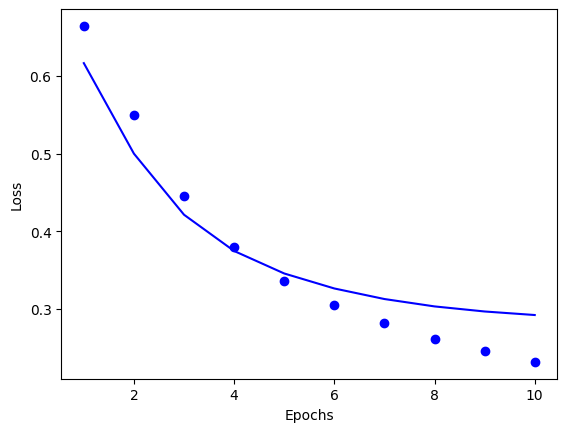

In [80]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

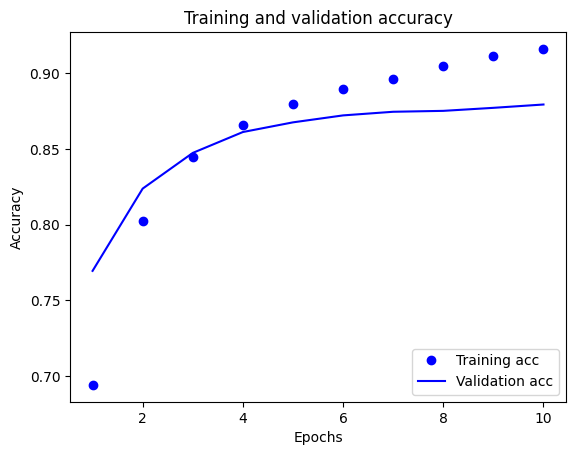

In [81]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

There's some overfitting going on here that could be mitigated with early stopping on the validation accuracy using `tf.keras.callbacks.EarlyStopping`

#### Model Export

In [82]:
# By adding the vectorize layer into the model, it can process raw strings. 
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3110 - accuracy: 0.8730
0.8730400204658508


In [83]:
# Try with new data
examples = ['What a fantastic movie',
            'I really did not like this move',
            'What a weird and strange experience. Like a grand dream of unknowing. That is how this movie felt']
export_model.predict(examples)

1/1 [==============================] - 0s 76ms/step


array([[0.624294  ],
       [0.42483723],
       [0.6255236 ]], dtype=float32)